<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/ipynb/Lesson%2020/20_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Обработка текстов с помощью нейронных сетей](https://colab.research.google.com/drive/1tPZPtZsEi4rv4J_4tcOBMDgyUNQDYKCX)
2. [Сравнение архитектур нейронных сетей для обработки текста](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
3. [Предварительно обученные векторные представления](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP)
4. Домашняя работа

В домашней работе необходимо выполнить следующее задание:

1. Подготовьте датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip) для обучения модели `Embedding` по аналогии с уроком [20.2](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
2. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для эмбендинга.
3. Заморозьте слой эмбединга.
4. Выберите любых 5 писателей и обучите модель на них, не забудьте про балансировку
(предварительно выделите 10% датасета на проверочную выборку и 10% на тестовую).
Выбирайте писателей с большими объемами текстов, что даст большее число примеров для обучения.
5. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
6. Если сможете добиться точности более 85% получите 4 балла.
7. Хотите 5 баллов независимо от точности? Изучите самостоятельно и примените токенизатор [Razdel](https://github.com/natasha/razdel#usage) для данной задачи, вместо встроенного токенизатора для Keras.

**Подсказка**. Так как проверка задания проводиться по средней точности на тестовых образцах (вычисляем по диагонали матрицы ошибок), то для улучшения данного показателя используйте колбэк функцию `keras.callbacks.ModelCheckpoint` из урока [19.2](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft) для сохранения лучшей эпохи.

**Подсказка 2**. Часто при работе с текстовыми данными вы можете заметить, что при использовании параметра `validation_split`, в методе `fit()`, точность на проверочной выборке ведет себя странно. В этом случае выделите проверочную выборку самостоятельно и используйте ее с помощью параметра `validation_data`.

In [9]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec razdel
%matplotlib inline

--2024-11-15 03:52:19--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.0MB/s    in 3.6s    

2024-11-15 03:52:24 (14.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [10]:
import glob
from collections import Counter
from typing import Dict, List

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    InputLayer,
    SpatialDropout1D,
)
from keras.models import Sequential
from keras.src.layers import InputLayer
from navec import Navec

# from keras.preprocessing.text import Tokenizer
from razdel import tokenize
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
)

In [11]:
# Шаг 1. Загрузка базы писателей Русской литературы
import keras
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip",
)
print(data_path)

/root/.keras/datasets/russian_literature.zip


In [12]:
import zipfile

zip_ref = zipfile.ZipFile(data_path, "r")
for file in zip_ref.namelist():
    try:
        zip_ref.extract(file, "./dataset")
    except OSError as e:
        if "[Errno 36] File name too long:" in str(e):
            new_filename = file[:50] + "." + file.split(".")[-1]
            with zip_ref.open(file) as source:
                with open(f"./dataset/{new_filename}", 'wb') as target:
                    target.write(source.read())


In [13]:
navec = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

In [14]:
# Шаг 3. Формирование датасета
CLASS_LIST = ["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Pushkin"]

# Загрузка необходимых библиотек

all_texts = {}  # Собираем в словарь весь датасет

for author in CLASS_LIST:
    # Инициализируем пустой строкой новый ключ словаря
    all_texts[author] = ""
    for path in glob.glob("./dataset/prose/{}/*.txt".format(author)) + glob.glob(
        "./dataset/poems/{}/*.txt".format(author)
    ):
        with open(f"{path}", "r", errors="ignore") as f:
            text = f.read()

        all_texts[author] += " " + text.replace("\n", " ")

In [15]:
# Шаг 4. Токенизация

embedding_dim = 300  # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000  # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

# tokenizer = Tokenizer(
#     num_words=max_words,
#     filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
#     lower=True,
#     split=" ",
#     char_level=False,
# )


class CustomTokenizer:
    def __init__(self, max_words: int = 10000):
        self.max_words = max_words
        self.word_index: Dict[str, int] = {}
        self.word_counts = Counter()
        self.oov_token = "<UNK>"

    def tokenize_text(self, text: str) -> List[str]:
        """Tokenize single text using razdel"""
        return [token.text.lower() for token in tokenize(text) if token.text.strip()]

    def fit_on_texts(self, texts) -> None:
        """Build vocabulary from list of texts"""
        # Collect word frequencies
        for text in texts:
            tokens = self.tokenize_text(text)
            self.word_counts.update(tokens)

        # Build vocabulary with most common words
        vocabulary = [self.oov_token] + [
            word for word, _ in self.word_counts.most_common(self.max_words - 1)
        ]

        # Create word to index mapping
        self.word_index = {word: idx for idx, word in enumerate(vocabulary)}

    def texts_to_sequences(self, texts) -> List[List[int]]:
        """Convert texts to sequences of indices"""
        sequences = []
        for text in texts:
            tokens = self.tokenize_text(text)
            sequence = [
                self.word_index.get(token, 0) for token in tokens
            ]  # 0 is OOV token
            sequences.append(sequence)
        return sequences

    def get_vocabulary_size(self) -> int:
        """Return size of vocabulary"""
        return len(self.word_index)


tokenizer = CustomTokenizer(max_words=max_words)

# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [16]:
# Шаг 5. Преобразование текста в последовательность

# Преобразуем текст в последовательности:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [17]:
# Шаг 6. Балансировка датасета
seq_train_balance = [seq_train[cls][:40000] for cls in range(len(CLASS_LIST))]

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f"Датасет состоит из {total} слов")

Датасет состоит из 240000 слов


In [18]:
print("Общая выборка по писателям (по словам):")
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(
        f"{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%"
    )
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print("Среднее значение слов: ", np.round(mean_list.mean()))
print("Медианное значение слов: ", np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 40000 слов, доля в общей базе: 16.67%
Tolstoy - 40000 слов, доля в общей базе: 16.67%
Turgenev - 40000 слов, доля в общей базе: 16.67%
Chekhov - 40000 слов, доля в общей базе: 16.67%
Lermontov - 40000 слов, доля в общей базе: 16.67%
Pushkin - 40000 слов, доля в общей базе: 16.67%
Среднее значение слов:  40000.0
Медианное значение слов:  40000.0


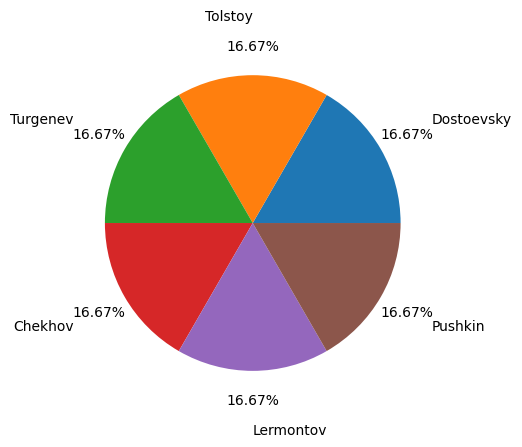

Форма входных данных для обучающей выборки: (1866, 1000)
Форма выходных данных (меток) для обучающей выборки: (1866, 6)
Форма входных данных для тестовой выборки: (186, 1000)
Форма выходных данных (меток) для тестовой выборки: (186, 6)
Форма входных данных для валидационной выборки: (186, 1000)
Форма выходных данных (меток) для валидационной выборки: (186, 6)


In [19]:
fig, ax = plt.subplots()
ax.pie(
    [
        len(i) for i in seq_train_balance
    ],  # формируем список значений как длина символов текста каждого автора
    labels=CLASS_LIST,  # список меток
    pctdistance=1.2,  # дистанция размещения % (1 - граница окружности)
    labeldistance=1.4,  # размещение меток (1 - граница окружности)
    autopct="%1.2f%%",  # формат для % (2 знака после запятой)
)
plt.show()

# Шаг 7. Нарезка примеров из текста методом скользящего окна
WIN_SIZE = 1000  # Ширина окна в токенах
WIN_STEP = 100  # Шаг окна в токенах


# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, step)
    ]


def seq_vectorize(
    seq_list,  # Последовательность
    test_split,  # Доля на тестовую сборку
    class_list,  # Список классов
    win_size,  # Ширина скользящего окна
    step,  # Шаг скользящего окна
):
    # Списки для результирующих данных
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Разбиваем на train/val/test с пропорцией 80/10/10
        # 100 * 1-0.2 = 80
        len_seq = len(seq_list[cls])
        gate_val_split = int(len_seq * (1 - test_split))
        gate_test_split = int(len_seq * (1 - test_split * 0.5))

        # Разбиваем последовательность токенов класса на отрезки для каждой выборки
        vectors_train = seq_split(seq_list[cls][:gate_val_split], win_size, step)
        vectors_val = seq_split(
            seq_list[cls][gate_val_split:gate_test_split], win_size, step
        )
        vectors_test = seq_split(seq_list[cls][gate_test_split:], win_size, step)

        # Добавляем отрезки в соответствующие выборки
        x_train += vectors_train
        x_val += vectors_val
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(
            vectors_train
        )
        y_val += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_val)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результаты как numpy-массивы
    return (
        np.array(x_train),
        np.array(y_train),
        np.array(x_val),
        np.array(y_val),
        np.array(x_test),
        np.array(y_test),
    )


x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(
    seq_train_balance, 0.2, CLASS_LIST, WIN_SIZE, WIN_STEP
)

print(f"Форма входных данных для обучающей выборки: {x_train.shape}")
print(f"Форма выходных данных (меток) для обучающей выборки: {y_train.shape}")
print(f"Форма входных данных для тестовой выборки: {x_test.shape}")
print(f"Форма выходных данных (меток) для тестовой выборки: {y_test.shape}")
print(f"Форма входных данных для валидационной выборки: {x_val.shape}")
print(f"Форма выходных данных (меток) для валидационной выборки: {y_val.shape}")

In [20]:
# Шаг 8. Определим вспомогательные функции
# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle("График процесса обучения модели")
    ax1.plot(history.history["accuracy"], label="График точности на обучающей выборке")
    ax1.plot(
        history.history["val_accuracy"], label="График точности на проверочной выборке"
    )
    ax1.xaxis.get_major_locator().set_params(
        integer=True
    )  # На оси х показываем целые числа
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("График точности")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающей выборке")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочной выборке")
    ax2.xaxis.get_major_locator().set_params(
        integer=True
    )  # На оси х показываем целые числа
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()


# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Матрица ошибок", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси
    plt.show()

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


# Архитектура сети
model = Sequential()
model.add(InputLayer(input_shape=(WIN_SIZE,)))
model.add(Embedding(max_words, embedding_dim))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation="softmax"))


word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


model.get_layer(index=0).set_weights([embedding_matrix])
model.get_layer(index=0).trainable = False

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - accuracy: 0.1993 - loss: 2.4376 - val_accuracy: 0.1989 - val_loss: 1.9328
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 552ms/step - accuracy: 0.8705 - loss: 0.3911 - val_accuracy: 0.3441 - val_loss: 1.6571
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 581ms/step - accuracy: 0.9542 - loss: 0.1259 - val_accuracy: 0.2634 - val_loss: 1.8909
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 553ms/step - accuracy: 0.9746 - loss: 0.0771 - val_accuracy: 0.1935 - val_loss: 2.1558
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 587ms/step - accuracy: 0.9894 - loss: 0.0457 - val_accuracy: 0.2151 - val_loss: 2.3690
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.9956 - loss: 0.0264 - val_accuracy: 0.2204 - val_loss: 2.2889
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 586ms/step - accuracy: 0.9933 - loss: 0.0279 - val_accuracy: 0.2258 - val_loss: 2.2934
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accu

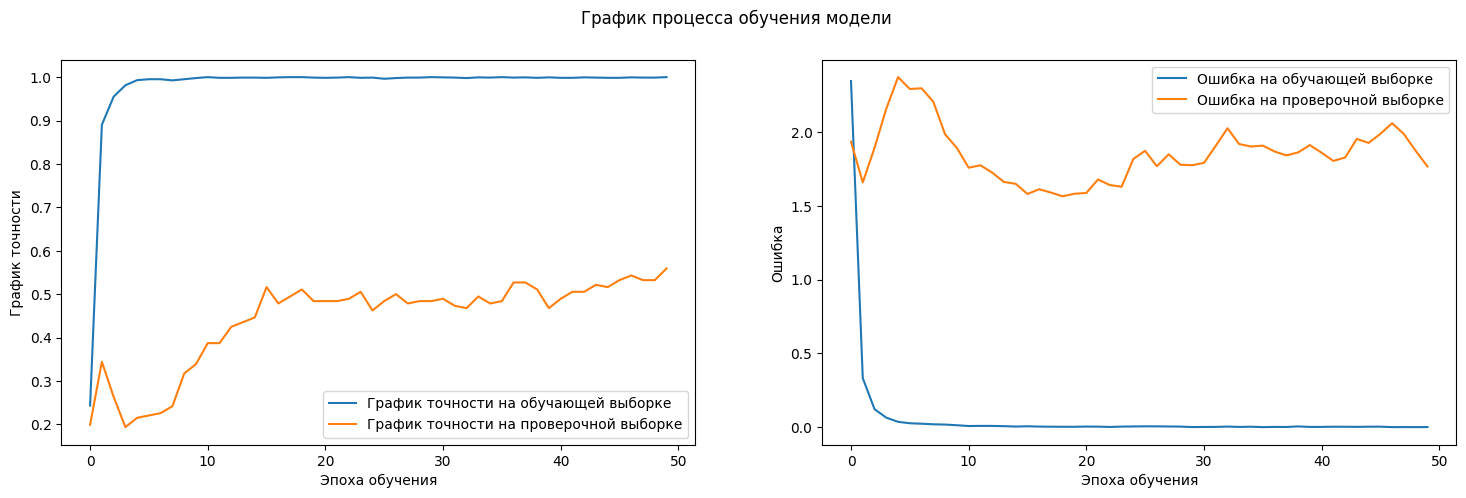

In [21]:
### Обучение модели
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    # validation_split=0.1
    validation_data=(x_val, y_val),
)
model.save_weights("pre_trained_model.weights.h5")

show_plot(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


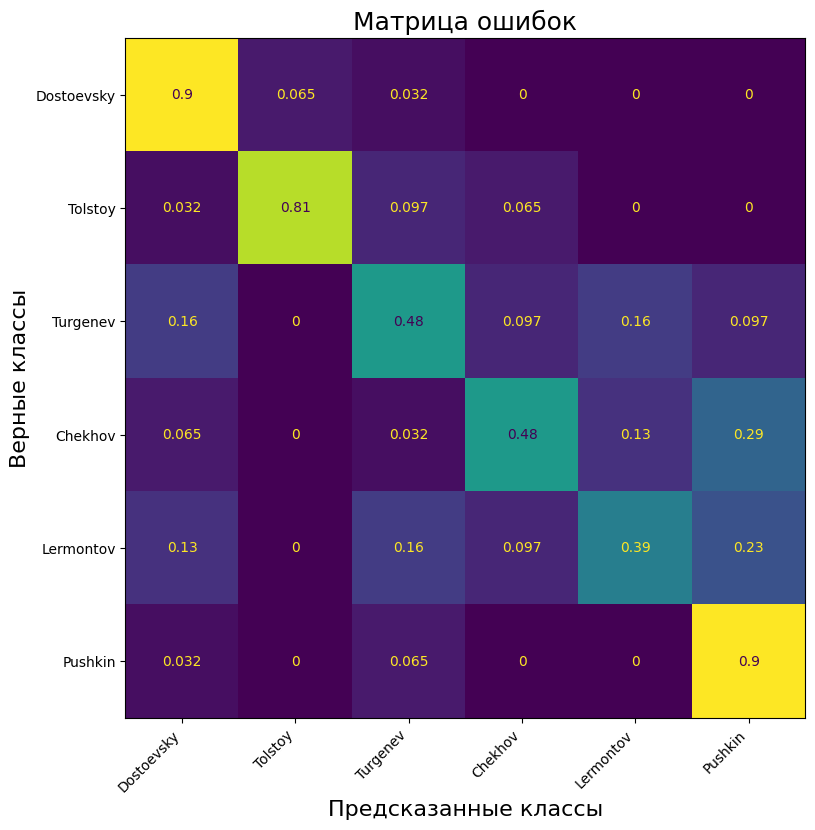


Средняя точность распознавания:  66%


In [22]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)